Jest to plik w którym znajduje się kod do trenowania pierwszej sieci przewidującej parametry do całościowego retuszu zdjęcia. 

In [3]:
import os
import numpy as np
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,GlobalAveragePooling2D,AveragePooling2D,Flatten,Dense, Add,Dropout,UpSampling2D,Conv2DTranspose,Activation,Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import backend as K
plt.rcParams['figure.figsize']=18,10

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
df_train=pd.read_csv(r"C:\Users\komej\Desktop\AutoEnhancer\values1.csv")
df_test=pd.read_csv(r"C:\Users\komej\Desktop\AutoEnhancer\values_test.csv")

Wszystkie etykiety do zdjęć z wartościami są zapisane w pliku csv. Wszystkie dane są zapisane w taki sposób aby miały mały rozstęp i mieściły się w jednym przedziale liczbowym oraz jak najmniejszą liczbę wartości odstających. Zbiór treningowy jest nieduży, ale będzie stale powiększany.

In [6]:
df_train.head(10)

,Unnamed: 0,Postprocessed,Postprocessed_raw,Whites,Blacks,Exposure,Gamma,Shadows,Highlights,Contrast,Dehaze,Temperature,Saturation,Tint,Denoise,Color_denoise,Sharpen
0,0,postprocessed/_DSC0501.png,postprocessed_raw/_DSC0501.png,10.0,-2,0.60,0.35,0.05,0.15,0.10,0.10,6600,6,1,0.50,0.35,0.25
1,1,postprocessed/_DSC7567.png,postprocessed_raw/_DSC7567.png,5.0,-2,0.55,0.36,0.05,0.05,0.12,0.05,8500,3,3,0.95,0.60,0.10
2,2,postprocessed/_DSC0111.png,postprocessed_raw/_DSC0111.png,3.0,-1,0.07,0.25,0.12,0.25,0.05,0.15,5800,5,-1,0.45,0.23,0.25
3,3,postprocessed/_DSC0120.png,postprocessed_raw/_DSC0120.png,4.0,-2,0.25,0.22,0.10,0.10,0.10,0.10,5700,8,-1,0.40,0.28,0.35
4,4,postprocessed/_DSC0128.png,postprocessed_raw/_DSC0128.png,0.0,0,0.04,0.30,0.08,0.15,0.00,0.10,5800,2,-1,0.25,0.20,0.27
5,5,postprocessed/_DSC0261.png,postprocessed_raw/_DSC0261.png,3.0,0,0.70,0.31,0.10,0.05,0.05,0.00,5500,3,-2,0.65,0.30,0.20
6,6,postprocessed/_DSC0265.png,postprocessed_raw/_DSC0265.png,5.0,0,0.50,0.20,0.10,0.00,0.10,0.00,5800,5,-1,0.45,0.25,0.22
7,7,postprocessed/_DSC0276.png,postprocessed_raw/_DSC0276.png,3.0,-1,0.52,0.55,0.11,0.07,0.07,0.05,6200,5,3,0.35,0.35,0.20
8,8,postprocessed/_DSC0451.png,postprocessed_raw/_DSC0451.png,-5.0,-1,0.29,0.60,0.10,0.15,0.05,0.10,5900,0,-1,0.10,0.30,0.20
9,9,postprocessed/_DSC0470.png,postprocessed_raw/_DSC0470.png,5.0,-1,0.18,0.35,0.10,0.15,0.07,0.00,5400,0,-2,0.30,0.30,0.21


In [7]:
del df_train['Unnamed: 0']

In [8]:
df_train.describe()

,Whites,Blacks,Exposure,Gamma,Shadows,Highlights,Contrast,Dehaze,Temperature,Saturation,Tint,Denoise,Color_denoise,Sharpen
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,2.694444,-0.583333,0.308333,0.285278,0.079167,0.085278,0.063611,0.093333,5808.333333,3.805556,-0.027778,0.423333,0.328889,0.305000
std,2.734117,1.250714,0.161767,0.103578,0.029314,0.056744,0.040578,0.096865,657.430061,1.894646,2.261303,0.177941,0.066538,0.075913
min,-5.000000,-2.000000,0.010000,0.100000,0.030000,-0.100000,-0.050000,0.000000,4300.000000,0.000000,-3.000000,0.100000,0.200000,0.100000
25%,1.750000,-1.000000,0.207500,0.200000,0.050000,0.050000,0.050000,0.022500,5500.000000,3.000000,-2.000000,0.307500,0.300000,0.250000
50%,3.000000,-1.000000,0.270000,0.285000,0.085000,0.095000,0.070000,0.100000,5800.000000,4.000000,-1.000000,0.385000,0.320000,0.300000
75%,4.000000,0.000000,0.400000,0.327500,0.100000,0.102500,0.100000,0.102500,6125.000000,5.000000,1.000000,0.500000,0.350000,0.355000
max,10.000000,5.000000,0.700000,0.600000,0.130000,0.250000,0.150000,0.450000,8500.000000,8.000000,7.000000,0.950000,0.600000,0.450000


Architektura sieci to klasyfikator połączony z Autoencoderem. Encoder to przetrenowana sieć VGG16, zakończona pierwszą warstwą GlobalAveragePooling2D, pośrodku jest warstwa łącząca encoder z decoderem. Zastosowane są również połączenia z warstawami z encodera, aby wyniki były lepsze. Na końcu jest druga warstwa GlobalAveragePooling2D uśredniająca dane i pomagająca lokalizować ważne cechy z danych, w przeciwieństwie do warstwy Flatten. Potem jest warstwa Concatenate, która łączy te 2 warstwy GAP, z różnymi reprezantacjami danych. Sieć ma 14 wyjść, czyli tyle ile parametrów potrzebnych do retuszu.

In [9]:
vgg=tf.keras.applications.VGG16(input_shape=(384,384,3),include_top=False,weights='imagenet')

vgg16=Model(vgg.input,vgg.get_layer('block5_pool').output)

def conv_block(inp,filters):
    conv1=Conv2D(filters,kernel_size=(5,5),padding='same',dilation_rate=2)(inp)
    #bn1=BatchNormalization()(conv1)
    ac1=Activation('relu')(conv1)
    return ac1

def decoder_block(inputs,skip,filters):
    x=UpSampling2D((2,2),interpolation='bilinear')(inputs)
    x=Conv2D(filters,kernel_size=(4,4),padding='same')(x)
    #x=Conv2DTranspose(filters,kernel_size=(4,4),padding='same',strides=2)(inputs)
    ad=Add()([x,skip])
    x1=conv_block(ad,filters)
    return x1


mid=Conv2D(512,kernel_size=(4,4),padding='same',activation='relu',strides=1)(vgg16.output)

d0=decoder_block(mid,vgg16.get_layer('block5_conv3').output,512)
d1=decoder_block(d0,vgg16.get_layer('block4_conv3').output,512)
d2=decoder_block(d1,vgg16.get_layer('block3_conv3').output,256)
d3=decoder_block(d2,vgg16.get_layer('block2_conv2').output,128)
d4=decoder_block(d3,vgg16.get_layer('block1_conv2').output,64)

x0=GlobalAveragePooling2D()(vgg16.output)
x=GlobalAveragePooling2D()(d4)
con=Concatenate()([x0,x])
x=Dense(1024,activation='relu')(con)


whites=Dense(1,name='whites')(x)
blacks=Dense(1,name='blacks')(x)
exposure=Dense(1,name='exposure')(x)
gamma=Dense(1,name='gamma')(x)
shadows=Dense(1,name='shadows')(x)
highlights=Dense(1,name='highlights')(x)
contrast=Dense(1,name='contrast')(x)
dehaze=Dense(1,name='dehaze')(x)
temp=Dense(1,name='temp')(x)
sat=Dense(1,name='sat')(x)
tint=Dense(1,name='tint')(x)
denoise=Dense(1,name='denoise')(x)
color=Dense(1,name='color')(x)
sharpen=Dense(1,name='sharpen')(x)

model=Model(vgg16.input,[whites,blacks,exposure,gamma,shadows,highlights,contrast,dehaze,temp,sat,tint,denoise,color,sharpen])

Sieć skompilowana jest w ten sposób: Optymalizator to Adam, początkowa szybkość uczenia to 1e-4, funkcje kosztu to w większości średni błąd kwadratowy(MSE), ale niektóre to średni błąd bezwzględny(MAE) ze względu na lekkie wartości odstające w zbiorze treningowym, a MAE radzi sobie z nimi znacznie lepiej niż MSE.

In [33]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss={'whites':'mae','blacks':'mse','exposure':'mse','gamma':'mse','shadows':'mse','highlights':'mse','contrast':'mse','dehaze':'mae','temp':'mse','sat':'mse','tint':'mae','denoise':'mse','color':'mse','sharpen':'mse'})

In [29]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 384, 384, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 384, 384, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

                                6)                                                                
                                                                                                  
 conv2d_18 (Conv2D)             (None, 192, 192, 12  524416      ['up_sampling2d_8[0][0]']        
                                8)                                                                
                                                                                                  
 add_8 (Add)                    (None, 192, 192, 12  0           ['conv2d_18[0][0]',              
                                8)                                'block2_conv2[0][0]']           
                                                                                                  
 conv2d_19 (Conv2D)             (None, 192, 192, 12  409728      ['add_8[0][0]']                  
                                8)                                                                
          

In [17]:
#Funkcja losowo wczytująca zdjęcia oraz etykiety do procesu trenowania sieci oraz odpowiednio je przetwarza 
def batch_gen(batch_size,df):
    while(1):
        path='C:/Users/komej/Desktop/AutoEnhancer/'
        batches=df.sample(n=batch_size)
        img_files=batches['Postprocessed_raw']
        img_arr=[]
        for i in img_files:
            img_arr.append(i)
        whites,blacks,exposure,gamma,shadows,highlights,contrast,dehaze,temp,sat,tint,denoise,color,sharpen=batches['Whites'],batches['Blacks'],batches['Exposure'],batches['Gamma'],batches['Shadows'],batches['Highlights'],batches['Contrast'],batches['Dehaze'],batches['Temperature'],batches['Saturation'], batches['Tint'],batches['Denoise'],batches['Color_denoise'],batches['Sharpen']
        #Skalowanie danych do tego samego zakresu
        whites=whites/100
        blacks=blacks/10
        temp=temp/10000
        sat=sat/100
        tint=tint/10
        images=[]
        for img in img_arr:
            img_train=cv2.imread(path+img)
            img_train=cv2.resize(img_train,(384,384),interpolation=cv2.INTER_AREA)
            images.append(img_train)
        images=np.array(images,dtype=np.float32)
        preprocessed_images=preprocess_input(images)/127.5
        yield(preprocessed_images,[np.array(whites),np.array(blacks),np.array(exposure),np.array(gamma),np.array(shadows),np.array(highlights),np.array(contrast),
                                   np.array(dehaze),np.array(temp),np.array(sat),np.array(tint),np.array(denoise),
                                   np.array(color),np.array(sharpen)])

In [18]:
#Funkcja umożliwiająca szacowanie skuteczności sieci podczas trenowania, wczytuje zbiór testowy
def test_gen(df):
    path='C:/Users/komej/Desktop/AutoEnhancer/'
    files=df['Postprocessed_raw']
    arr=[]
    for i in files:
        arr.append(i)
    whites,blacks,exposure,gamma,shadows,highlights,contrast,dehaze,temp,sat,tint,denoise,color,sharpen=df['Whites'],df['Blacks'],df['Exposure'],df['Gamma'],df['Shadows'],df['Highlights'],df['Contrast'],df['Dehaze'],df['Temperature'],df['Saturation'], df['Tint'],df['Denoise'],df['Color_denoise'],df['Sharpen']
    whites=whites/100
    blacks=blacks/10
    temp=temp/10000
    sat=sat/100
    tint=tint/10
    images=[]
    for img in arr:
        img_train=cv2.imread(path+img)
        img_train=cv2.resize(img_train,(384,384),interpolation=cv2.INTER_AREA)
        images.append(img_train)
    images=np.array(images,dtype=np.float32)
    preprocessed_images=preprocess_input(images)/127.5
    return(preprocessed_images,[np.array(whites),np.array(blacks),np.array(exposure),np.array(gamma),np.array(shadows),np.array(highlights),np.array(contrast),
                                np.array(dehaze),np.array(temp),np.array(sat),np.array(tint),np.array(denoise),
                                np.array(color),np.array(sharpen)])

In [19]:
#Funkcja do zmiany szybkości uczenia, wraz z zwiększającą się liczbą epok
def decay_schedule(epoch, lr):
    if (epoch % 100 == 0) and (epoch != 0):
        lr = lr * 0.1
    return lr

In [34]:
#Pętla treningowa
batch_size=4
epochs=10
train_l,test_l,test_e=[],[],[]
batch=batch_gen(batch_size,df_train)
img_test,labels_test=test_gen(df_test)
for e in range(1,epochs+1):
    imgs,y=next(batch)
    current_lr=K.eval(model.optimizer.learning_rate)
    nlr=decay_schedule(e,current_lr)
    K.set_value(model.optimizer.learning_rate,nlr)
    loss=model.train_on_batch(imgs,y)
    test_loss=model.test_on_batch(img_test,labels_test)
    train_l.append(loss[0])
    test_l.append(test_loss[0])
    test_e.append(e)
    print('Epoch:',e)
    print('Train_Loss:',loss)
    print('Test_Loss:',test_loss)

Epoch: 1
Train_Loss: [0.24319303035736084, 0.04771347716450691, 0.017084892839193344, 0.006791329011321068, 0.003926451783627272, 0.0011289911344647408, 0.004276817664504051, 0.005303319077938795, 0.06621892750263214, 0.002629217691719532, 0.001556150964461267, 0.06352107971906662, 0.017651671543717384, 0.0043480475433170795, 0.0010426674271002412]
Test_Loss: [0.3989337384700775, 0.049494534730911255, 0.006969430949538946, 0.021259596571326256, 0.0860440731048584, 0.001079428126104176, 0.00374736194498837, 0.0017936757067218423, 0.04109261557459831, 0.0057353912852704525, 0.0006374548538587987, 0.10994589328765869, 0.042256202548742294, 0.021488433703780174, 0.007389650214463472]
Epoch: 2
Train_Loss: [0.2290303260087967, 0.04831267148256302, 0.016659025102853775, 0.011160789988934994, 0.008512675762176514, 0.0007006996893323958, 0.0006193903973326087, 0.0010370591189712286, 0.0507773794233799, 0.0017887660069391131, 0.002995604183524847, 0.0670633316040039, 0.013751743361353874, 0.0045

In [101]:
del test_l[:3]
del train_l[:3]
del test_e[:3]

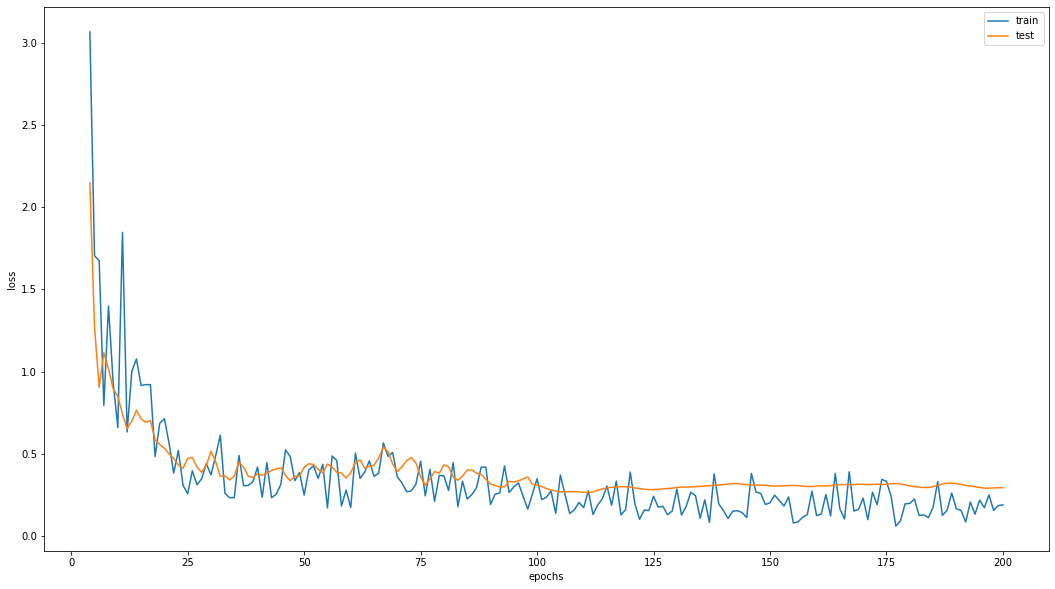

In [102]:
plt.plot(test_e,train_l,label='train')
plt.plot(test_e,test_l,label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [35]:
#Kod służący do sprawdzenia wyników z zbiorem testowym a prognozą modelu
to_pred=df_test['Postprocessed_raw']
predicted_val=[]
#prognozowanie
for im in to_pred:
    img_to_pred=cv2.imread('C:/Users/komej/Desktop/AutoEnhancer/'+im)
    img_to_pred=cv2.resize(img_to_pred,(384,384),interpolation=cv2.INTER_AREA)
    img_to_pred=preprocess_input(img_to_pred)/127.5
    img_to_pred=np.expand_dims(img_to_pred,axis=0)
    score=model.predict(img_to_pred)
    predicted_val.append(np.array(score)[:,:,0])
#Zaokrąglanie wartości aby były takie same
predicted_val=np.array(predicted_val)
predicted_val=np.transpose(predicted_val[:,:,0],(1,0))
predicted_val[0]=np.round_(predicted_val[0],2)
predicted_val[1]=np.round_(predicted_val[1],1)
predicted_val[2:10]=np.round_(predicted_val[2:10],2)
predicted_val[10]=np.round_(predicted_val[10],1)
predicted_val[11:]=np.round_(predicted_val[11:],2)

In [36]:
#rezultat z modelu
predicted_val

array([[ 0.03,  0.02,  0.04,  0.04,  0.02,  0.01],
       [-0.  ,  0.  , -0.  ,  0.  ,  0.  , -0.1 ],
       [ 0.49,  0.31,  0.28,  0.25,  0.55,  0.26],
       [ 0.28,  0.35,  0.31,  0.27,  0.32,  0.38],
       [ 0.08,  0.11,  0.14,  0.12,  0.09,  0.13],
       [ 0.1 ,  0.06,  0.04,  0.02,  0.08,  0.05],
       [ 0.05,  0.05,  0.06,  0.09,  0.05,  0.06],
       [ 0.01,  0.22,  0.22,  0.25,  0.09,  0.12],
       [ 0.49,  0.62,  0.61,  0.55,  0.5 ,  0.68],
       [ 0.01,  0.05,  0.04,  0.02,  0.02,  0.01],
       [-0.2 ,  0.1 ,  0.2 ,  0.1 , -0.1 ,  0.  ],
       [ 0.51,  0.36,  0.29,  0.3 ,  0.49,  0.27],
       [ 0.35,  0.31,  0.29,  0.3 ,  0.33,  0.21],
       [ 0.36,  0.29,  0.28,  0.28,  0.33,  0.3 ]], dtype=float32)

In [37]:
#prawdziwe etykiety
np.array(labels_test)

array([[ 0.03,  0.  , -0.01,  0.01,  0.  , -0.01],
       [-0.1 , -0.1 ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.69,  0.16,  0.19,  0.17,  0.35,  0.07],
       [ 0.45,  0.47,  0.39,  0.35,  0.85,  0.25],
       [ 0.07,  0.15,  0.1 ,  0.07,  0.07,  0.04],
       [ 0.  ,  0.08,  0.1 ,  0.08,  0.1 ,  0.12],
       [ 0.1 ,  0.08,  0.1 ,  0.1 ,  0.07,  0.07],
       [ 0.  ,  0.25,  0.19,  0.15,  0.05,  0.1 ],
       [ 0.6 ,  0.65,  0.61,  0.6 ,  0.61,  0.59],
       [ 0.04,  0.03,  0.03,  0.01,  0.03,  0.03],
       [-0.1 ,  0.1 , -0.1 ,  0.  , -0.1 , -0.2 ],
       [ 0.4 ,  0.32,  0.15,  0.15,  0.62,  0.12],
       [ 0.2 ,  0.2 ,  0.25,  0.2 ,  0.2 ,  0.22],
       [ 0.35,  0.25,  0.33,  0.35,  0.2 ,  0.28]])

In [38]:
print('Średnia dla etykiet:',np.mean(labels_test),'Średnia dla wyników:',np.mean(predicted_val))

Średnia dla etykiet: 0.17464285714285713 Średnia dla wyników: 0.18988097


In [39]:
print('Odchylenie Standardowe dla etykiet:',np.std(labels_test),'Odchylenie Standardowe dla wyników:',np.std(predicted_val))

Odchylenie Standardowe dla etykiet: 0.2111219825044248 Odchylenie Standardowe dla wyników: 0.18501927


In [40]:
mse_eval=tf.keras.metrics.mean_squared_error(labels_test,predicted_val).numpy()
print('Whites:',mse_eval[0]*100)
print('Blacks:',mse_eval[1]*10)
print('Exposure:',mse_eval[2])
print('Gamma:',mse_eval[3])
print('Shadows:',mse_eval[4])
print('Higlights:',mse_eval[5])
print('Contrast:',mse_eval[6])
print('Dehaze:',mse_eval[7])
print('Temperature:',mse_eval[8]*10000)
print('Saturation:',mse_eval[9]*100)
print('Tint:',mse_eval[10]*10)
print('Denoise:',mse_eval[11])
print('Color_denoise:',mse_eval[12])
print('Sharpen:',mse_eval[13])

Whites: 0.07666666060686111
Blacks: 0.050000003539025784
Exposure: 0.025516666
Gamma: 0.058983337
Shadows: 0.0023833334
Higlights: 0.0038166668
Contrast: 0.00093333336
Dehaze: 0.0023166665
Temperature: 59.50001999735832
Saturation: 0.0333333300659433
Tint: 0.2500000037252903
Denoise: 0.015866665
Color_denoise: 0.010533334
Sharpen: 0.0044000004


In [41]:
#Sortowanie od największego
print(np.sort(mse_eval)[::-1])

[0.05898334 0.02551667 0.025      0.01586667 0.01053333 0.00595
 0.005      0.0044     0.00381667 0.00238333 0.00231667 0.00093333
 0.00076667 0.00033333]


In [42]:
#Sortowanie od najmniejszego
print(np.sort(mse_eval))

[0.00033333 0.00076667 0.00093333 0.00231667 0.00238333 0.00381667
 0.0044     0.005      0.00595    0.01053333 0.01586667 0.025
 0.02551667 0.05898334]


In [43]:
#Średni błąd bezwzględny na zbiorze testowym
mae_eval=tf.keras.metrics.mean_absolute_error(labels_test,predicted_val).numpy()
print('Whites:',mae_eval[0]*10)
print('Blacks:',mae_eval[1]*10)
print('Exposure:',mae_eval[2])
print('Gamma:',mae_eval[3])
print('Shadows:',mae_eval[4])
print('Higlights:',mae_eval[5])
print('Contrast:',mae_eval[6])
print('Dehaze:',mae_eval[7])
print('Temperature:',mae_eval[8]*10000)
print('Saturation:',mae_eval[9]*10)
print('Tint:',mae_eval[10]*10)
print('Denoise:',mae_eval[11])
print('Color_denoise:',mae_eval[12])
print('Sharpen:',mae_eval[13])

Whites: 0.2333333157002926
Blacks: 0.5000000074505806
Exposure: 0.15166666
Gamma: 0.185
Shadows: 0.041666668
Higlights: 0.055000003
Contrast: 0.026666665
Dehaze: 0.03833333
Temperature: 650.0000506639481
Saturation: 0.1666666753590107
Tint: 1.1666666716337204
Denoise: 0.120000005
Color_denoise: 0.089999996
Sharpen: 0.053333342


In [44]:
#Sortowanie od największego
print(np.sort(mae_eval)[::-1])

[0.185      0.15166666 0.12       0.11666667 0.09       0.06500001
 0.055      0.05333334 0.05       0.04166667 0.03833333 0.02666667
 0.02333333 0.01666667]


In [45]:
#Sortowanie od najmniejszego
print(np.sort(mae_eval))

[0.01666667 0.02333333 0.02666667 0.03833333 0.04166667 0.05
 0.05333334 0.055      0.06500001 0.09       0.11666667 0.12
 0.15166666 0.185     ]


Jak widać na tabelach porównawczych wartości przewidziane przez sieć bardzo dobrze są dobierane w stosunku do prawdziwych. Model najlepsze wartości MSE osiąga w Saturation, Whites i Contrast, a najgorsze w Gamma, Tint i Exposure. Ogólnie są to zadowalające wyniki, porównania graficzne w innym pliku.

In [111]:
model.save('C:/Users/komej/Desktop/AutoEnhancer/enh12-384.h5')